In [2]:
import parent

In [3]:
import networks


In [4]:
import data

In [46]:
d1, d2 = data.get_dataset_triangles(
    "train", data_size=28, hollow=True
)

In [43]:
image_A, image_B = (x[0].cuda() for x in next(zip(d1, d2)))

In [50]:
import torch
from torch import nn
import numpy as np
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN

import torch.nn.functional as F

class DenseMatrixNet(nn.Module):
    def __init__(self, size=28):
        super(DenseMatrixNet, self).__init__()
        self.size=size
        self.dense1 = nn.Linear(size *size  * 2, 8000)
        self.dense2 = nn.Linear(8000, 3000)
        self.dense3 = nn.Linear(3000, 12)
        torch.nn.init.zeros_(self.dense3.weight)

    def forward(self, x, y):
        x = torch.reshape(torch.cat([x, y], 1), (-1, 2 * self.size * self.size))
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        x = torch.reshape(x, (-1, 3, 4))
        x = torch.cat([x, torch.Tensor([[[0, 0, 0, 1]]]).cuda().expand(x.shape[0], -1, -1)], 1)
        x = x + torch.Tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]).cuda()
        return x


class InverseConsistentAffineNet(nn.Module):
    def __init__(self, network, lmbda, input_shape):
        super(InverseConsistentAffineNet, self).__init__()

        self.sz = np.array(input_shape)
        self.spacing = 1.0 / (self.sz[2::] - 1)

        _id = identity_map_multiN(self.sz, self.spacing)
        self.register_buffer("identityMap", torch.from_numpy(_id))
        self.map_shape = self.identityMap.shape
        self.regis_net = network
        self.lmbda = lmbda

    def adjust_batch_size(self, BATCH_SIZE):
        self.sz[0] = BATCH_SIZE
        self.spacing = 1.0 / (self.sz[2::] - 1)

        _id = identity_map_multiN(self.sz, self.spacing)
        self.register_buffer("identityMap", torch.from_numpy(_id))

    def forward(self, image_A, image_B):
        #Compute Displacement Maps
        self.matrix_AB = self.regis_net(image_A, image_B)
        
        self.phi_AB = torch.einsum("ijkl,ijm->imkl", self.identityMap, self.matrix_AB)

        self.matrix_BA = self.regis_net(image_B, image_A)

        #Compute Image similarity

        self.warped_image_A = compute_warped_image_multiNC(
            image_A, self.phi_AB, self.spacing, 1
        )

        self.warped_image_B = compute_warped_image_multiNC(
            image_B, self.phi_BA, self.spacing, 1
        )

        similarity_loss = torch.mean((self.warped_image_A - image_B) ** 2) + torch.mean(
            (self.warped_image_B - image_A) ** 2
        )
        
        #Compute Inverse Consistency
        #One way

        Iepsilon = (
            self.identityMap
            + torch.randn(*self.map_shape).cuda() * 1 / self.map_shape[-1]
        )

        D_BA_epsilon = compute_warped_image_multiNC(
            self.D_BA, Iepsilon, self.spacing, 1
        )

        self.approximate_identity = (
            compute_warped_image_multiNC(
                self.D_AB, D_BA_epsilon + Iepsilon, self.spacing, 1
            )
            + D_BA_epsilon
        )
        #And the Other
        D_AB_epsilon = compute_warped_image_multiNC(
            self.D_AB, Iepsilon, self.spacing, 1
        )

        self.approximate_identity2 = (
            compute_warped_image_multiNC(
                self.D_BA, D_AB_epsilon + Iepsilon, self.spacing, 1
            )
            + D_AB_epsilon
        )

        inverse_consistency_loss = self.lmbda * torch.mean(
            (self.approximate_identity) ** 2 + (self.approximate_identity2)**2
        )
        transform_magnitude = self.lmbda * torch.mean(
            (self.identityMap - self.phi_AB) ** 2
        )
        self.all_loss = inverse_consistency_loss + similarity_loss
        return [
            x
            for x in (
                self.all_loss,
                inverse_consistency_loss,
                similarity_loss,
                transform_magnitude,
            )
        ]
class MapToFunctionNet(nn.Module):
    def __init__(self, network, input_shape):
        pass 

In [51]:
net = InverseConsistentAffineNet(DenseMatrixNet(), 2048, next(iter(d1))[0].size())
net.cuda()

InverseConsistentAffineNet(
  (regis_net): DenseMatrixNet(
    (dense1): Linear(in_features=1568, out_features=8000, bias=True)
    (dense2): Linear(in_features=8000, out_features=3000, bias=True)
    (dense3): Linear(in_features=3000, out_features=12, bias=True)
  )
)

In [52]:
qq = net(image_A, image_B)

TypeError: einsum() missing 1 required positional argument: 'equation'

RuntimeError: more operands in equation than tensors

In [34]:
image_A.expand?

In [12]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [68]:
with open("../results/medrestrain_longtime_3090/loss_curve", "rb") as f:
    loss = pickle.load(f)

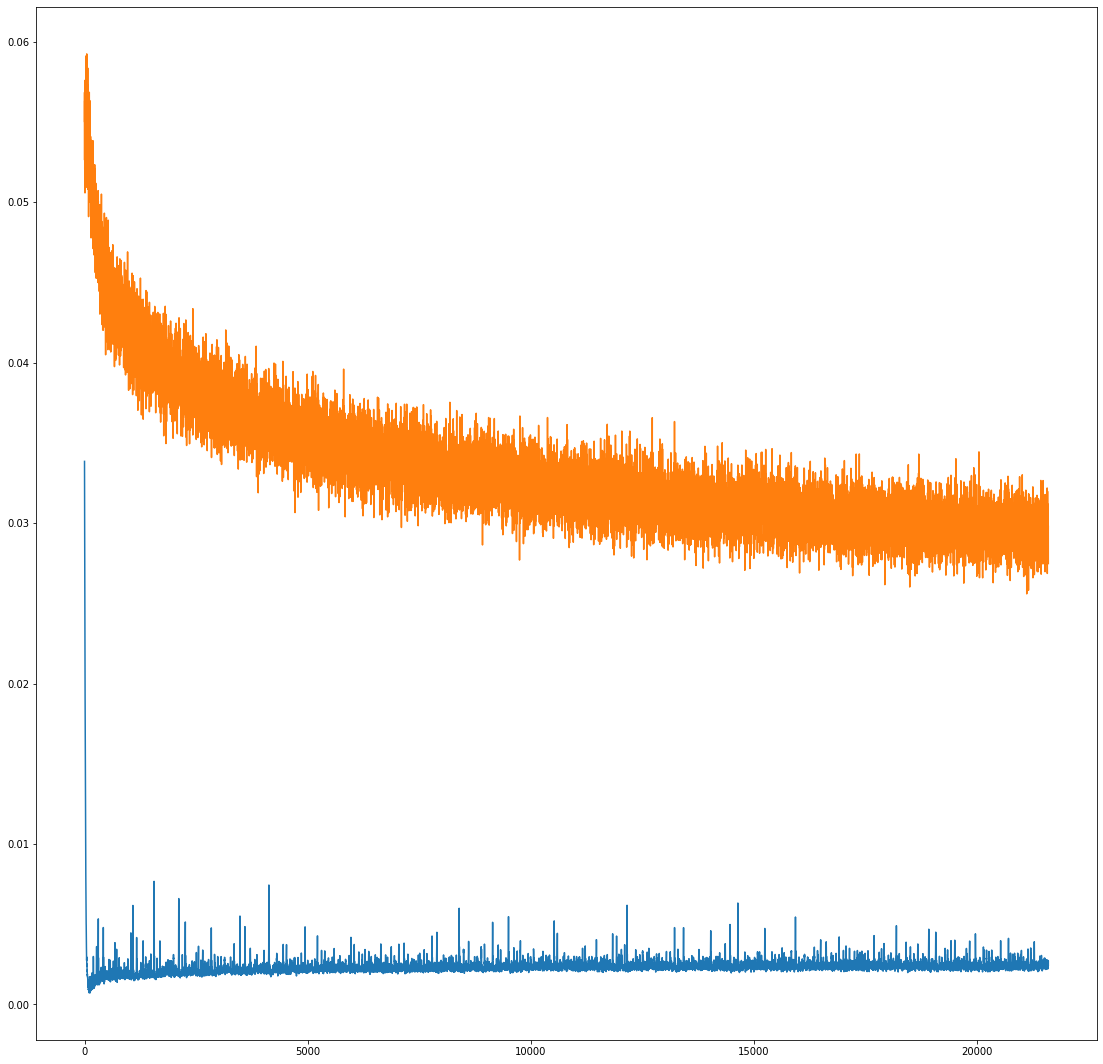

In [69]:
plt.plot(np.array(loss)[:, :2])

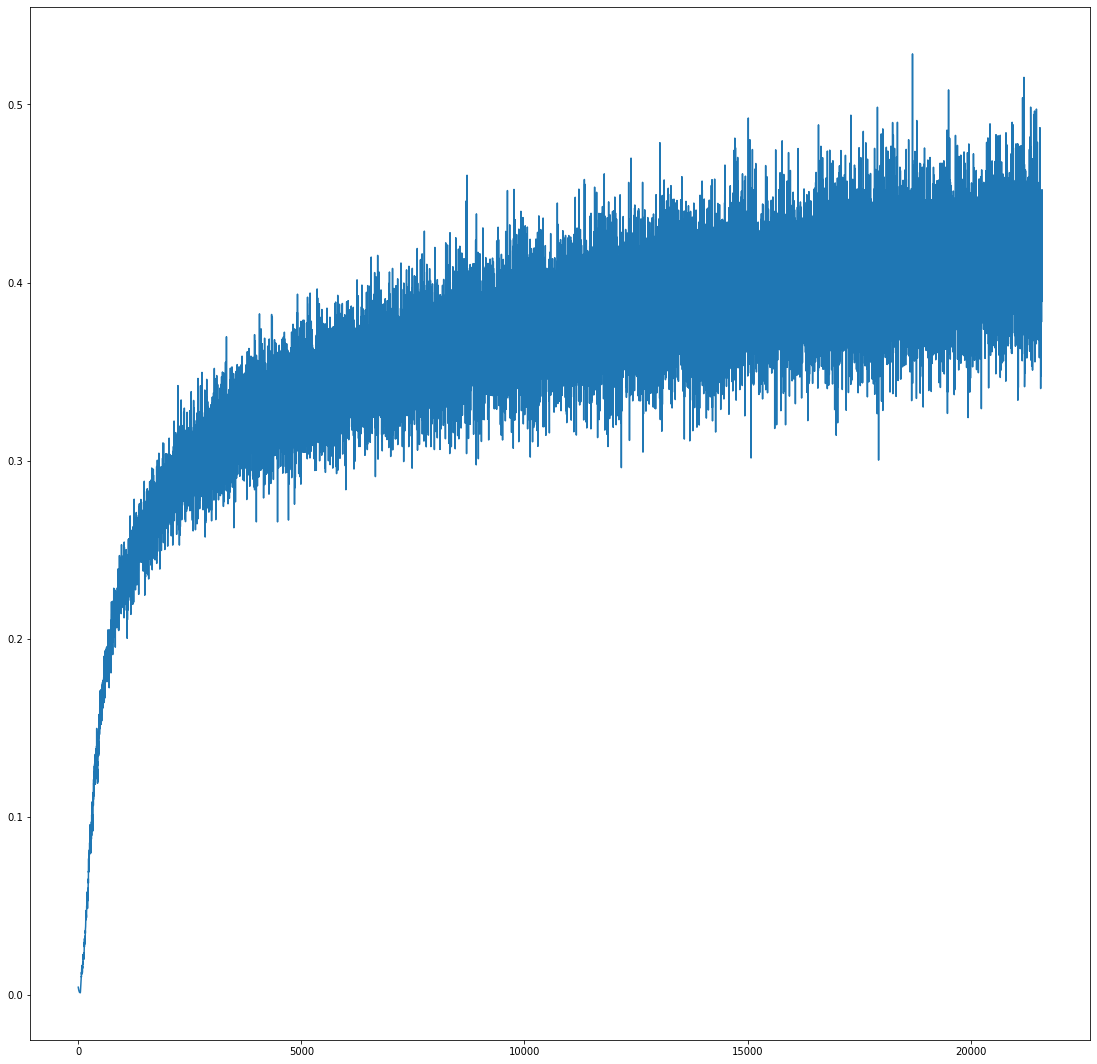

In [70]:
plt.plot(np.array(loss)[:, 2])

In [71]:
ls

CreateSunnysidePickle.py.ipynb  phi_map_array.pickle  Untitled.ipynb
NoNetwork.ipynb                 __pycache__/
parent.py                       Untitled1.ipynb


In [81]:
fnames = [
    "../results/BNE_parallel_batchnorm/",
    "../results/BNE_parallel_groupnorm/",
    "../results/BNE_parallel_none/",

    "../results/BNE_sequential_groupnorm_correct/",
    "../results/BNE_sequential_none_correct/",
        "../results/BNE_sequential_batchnorm_correct/",
]
curves = []
for f in fnames:
    with open(f + "loss.pickle", "rb") as ff:
        curves.append(pickle.load(ff))


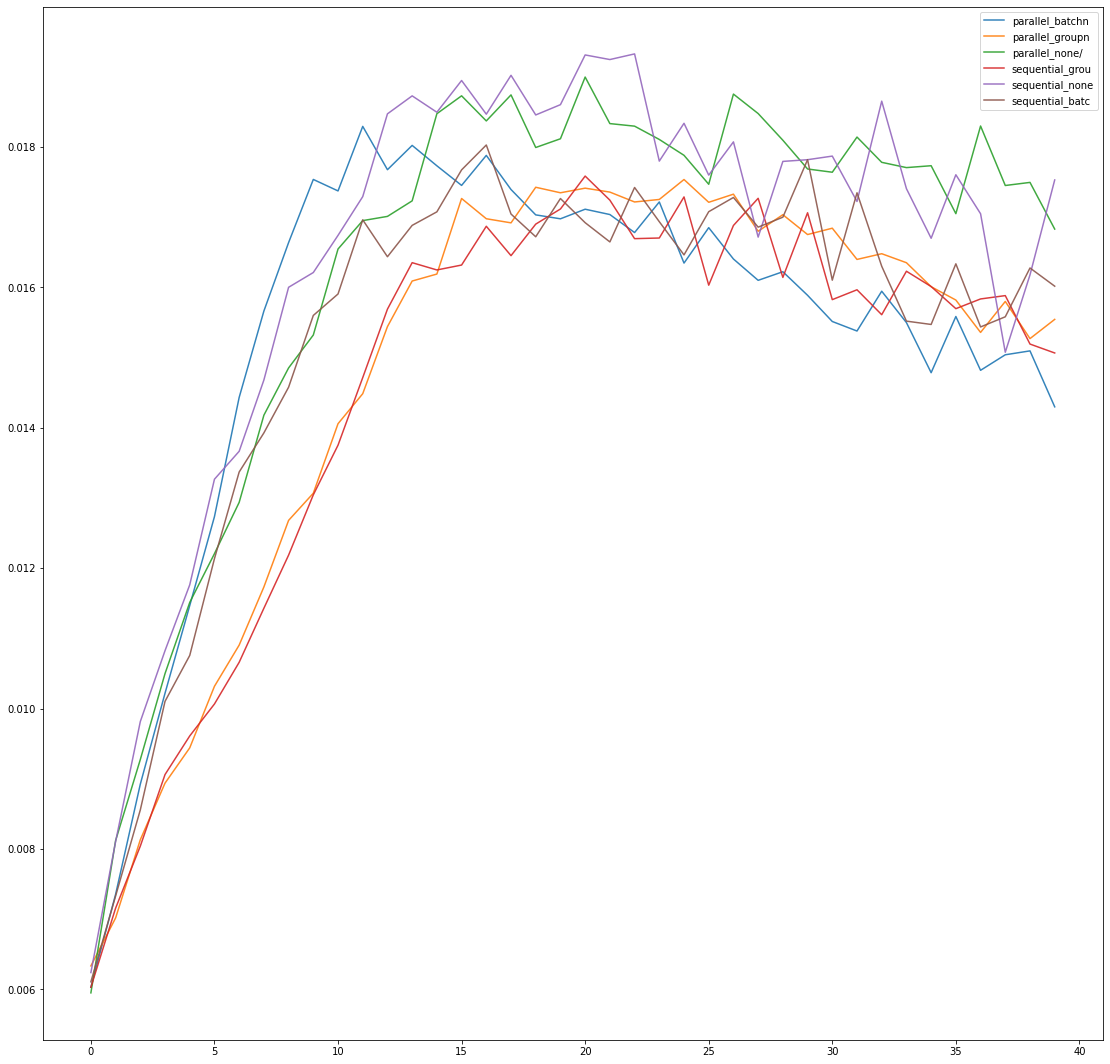

In [85]:

for c, name in zip(curves, fnames):
    curve = c[:, 0]
    curve = curve.reshape(-1, 50)
    curve = np.sum(curve, axis=1) / 50
    plt.plot(curve, label=name[15:30], alpha=.9)
plt.legend()

In [33]:
plt.rcParams["figure.figsize"] = (19, 19)

In [47]:
c.shape

(800, 4)